## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

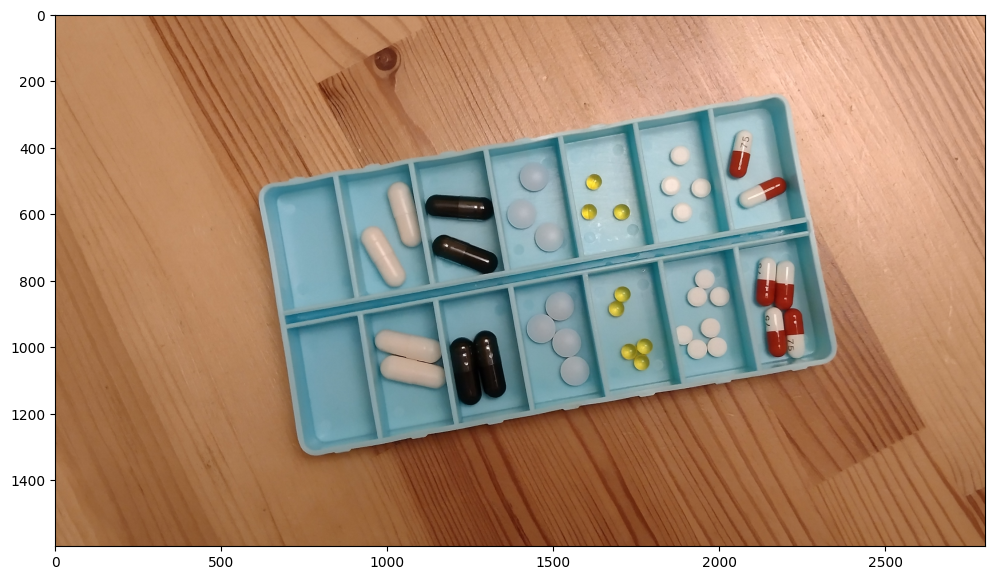

In [2]:
calib = cv2.imread('calib.png')[..., ::-1]
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [3]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [4]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [5]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    # TU BĘDZIE TWOJA IMPLEMENTACJA DETEKTORA
    raise NotImplementedError

In [10]:
import cv2
import numpy as np
from typing import List, Any
from matplotlib import pyplot as plt

class PillType:
    PROBIO = 1
    CARBON = 2
    KETO = 3
    ESPU = 4
    BIOX = 5
    LINE = 6

class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    pills = []
    pills_types = kwargs.get('pilltype', None)

    def angle_of_line(x1, y1, x2, y2):
            return np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi  

    def parallel_line_distance(line1, line2):
        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2
        
        angle1 = angle_of_line(x1, y1, x2, y2)
        angle2 = angle_of_line(x3, y3, x4, y4)
        
        if abs(angle1 - angle2) < min_angle_diff:
            a = y2 - y1
            b = x1 - x2
            c = x2 * y1 - x1 * y2
            
            distance = abs(a * x3 + b * y3 + c) / np.sqrt(a**2 + b**2)
            
            return distance
        else:
            return None


    if PillType.ESPU in pills_types:
        hsv_calib = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_yellow = np.array([20, 100, 100])   
        upper_yellow = np.array([40, 255, 255])   

        mask_yellow = cv2.inRange(hsv_calib, lower_yellow, upper_yellow)
        new = np.zeros_like(image)
        circles = cv2.HoughCircles(
            mask_yellow, 
            cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=200, param2=12, minRadius=5, maxRadius=30)

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")

            for x, y, r in circles:
                w = h = 2 * r  
                
                pill_type = PillType.ESPU 
                location = (x - r, y - r, w, h)  

                pill = Pill(pill_type, location)
                pills.append(pill)

    if PillType.PROBIO in pills_types:
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        h_lower = 10
        h_upper = 30

        thresh = cv2.inRange(h, h_lower, h_upper)

        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 5)), iterations=7)

        output_image = np.zeros_like(image) 
        final_mask = np.zeros_like(opened) 

        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) >= 5:  
                ellipse = cv2.fitEllipse(contour)
                center, axes, angle = ellipse

                if 500 > axes[0] > 50 and 500 > axes[1] > 150:
                    cv2.ellipse(output_image, ellipse, (0, 255, 0), 2)  

                    for y in range(0, opened.shape[0]):
                        for x in range(0, opened.shape[1]):
                            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:  
                                if opened[y, x] == 255:
                                    final_mask[y, x] = 255 
                                else:
                                    final_mask[y, x] = 0  

        probio_mask = final_mask.copy()

        contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)

            largest_object_mask = np.zeros_like(final_mask)  
            cv2.drawContours(largest_object_mask, [largest_contour], -1, 255, thickness=cv2.FILLED) 

            calib_masked = cv2.bitwise_and(image, image, mask=largest_object_mask)
        edges = cv2.Canny(calib_masked, 25, 50)

        lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=40, minLineLength=50, maxLineGap=5)

        min_distance = 20
        min_angle_diff = 20  

        drawn_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                
                dx = x2 - x1
                dy = y2 - y1
                
                line_length = np.sqrt(dx**2 + dy**2)
                
                scale = 1.25 
                
                new_x1 = int(x1 - scale * dx)
                new_y1 = int(y1 - scale * dy)
                new_x2 = int(x2 + scale * dx)
                new_y2 = int(y2 + scale * dy)
                
                drawn_lines.append((new_x1, new_y1, new_x2, new_y2))  

        max_distance = 0
        extreme_lines = (None, None)  

        for i, line1 in enumerate(drawn_lines):
            for j, line2 in enumerate(drawn_lines):
                if i != j:
                    dist = parallel_line_distance(line1, line2)
                    if dist is not None and dist > max_distance:
                        max_distance = dist
                        extreme_lines = (line1, line2)

        centers = []
        for line in extreme_lines:
            if line is not None:
                x1, y1, x2, y2 = line
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                centers.append((center_x, center_y))


        if len(centers) == 2:

            x1, y1 = centers[0]
            x2, y2 = centers[1]
            
            midpoint_x = (x1 + x2) // 2
            midpoint_y = (y1 + y2) // 2
            midpoint = (midpoint_x, midpoint_y)

            final_image = np.copy(calib_masked)
            cv2.circle(final_image, midpoint, 5, (0, 0, 255), -1)  

            for line in drawn_lines:
                if line != extreme_lines[0] and line != extreme_lines[1]:
                    x1, y1, x2, y2 = line
                    for x in range(min(x1, x2), max(x1, x2)):
                        y = int(((y2 - y1) * (x - x1)) / (x2 - x1) + y1) 
                        
                        if abs(x - midpoint_x) < 5 and abs(y - midpoint_y) < 5:
                            cv2.line(probio_mask, (x1, y1), (x2, y2), (0, 0, 0), 2)  

        contours, _ = cv2.findContours(probio_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours: 
                if contour.size > 10: 
                    x, y, w, h = cv2.boundingRect(contour)
                    location = (x, y, w, h)

                    pill_type = PillType.PROBIO  

                    pill = Pill(pill_type, location)
                    pills.append(pill)
    

    if PillType.CARBON in pills_types:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        binary_calib = cv2.threshold(v, 50, 255, cv2.THRESH_BINARY_INV)[1]
        
        ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        open_mask = cv2.morphologyEx(binary_calib, cv2.MORPH_OPEN, ellipse_kernel)
        closed_mask = cv2.morphologyEx(open_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30)))
        carbon_mask = closed_mask.copy()

        contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(contour) for contour in contours]

        max_area = max(areas)
        threshold_area = max_area / 1.5
        filtered_mask = np.zeros_like(closed_mask)

        for contour, area in zip(contours, areas):
            if area >= threshold_area:
                cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)

        inverted_mask = cv2.bitwise_not(filtered_mask)
        new_image = np.ones_like(image) * 255
        new_image[inverted_mask == 0] = image[inverted_mask == 0]

        if max(areas) >= 1.5 * min(areas):
            edges = cv2.Canny(new_image, 25, 50)
            lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=30, maxLineGap=5)

            drawn_lines = []
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    dx, dy = x2 - x1, y2 - y1
                    scale = 1.35
                    new_x1 = int(x1 - scale * dx)
                    new_y1 = int(y1 - scale * dy)
                    new_x2 = int(x2 + scale * dx)
                    new_y2 = int(y2 + scale * dy)
                    drawn_lines.append((new_x1, new_y1, new_x2, new_y2))

            max_distance = 0
            extreme_lines = (None, None)
            for i, line1 in enumerate(drawn_lines):
                for j, line2 in enumerate(drawn_lines):
                    if i != j:
                        dist = parallel_line_distance(line1, line2)
                        if dist is not None and dist > max_distance:
                            max_distance = dist
                            extreme_lines = (line1, line2)

            centers = []
            for line in extreme_lines:
                if line is not None:
                    x1, y1, x2, y2 = line
                    center_x = (x1 + x2) // 2
                    center_y = (y1 + y2) // 2
                    centers.append((center_x, center_y))

            if len(centers) == 2:
                x1, y1 = centers[0]
                x2, y2 = centers[1]
                midpoint_x = (x1 + x2) // 2
                midpoint_y = (y1 + y2) // 2

                new_image_with_lines = np.copy(new_image)
                for line in drawn_lines:
                    if line not in extreme_lines:
                        x1, y1, x2, y2 = line
                        for x in range(min(x1, x2), max(x1, x2)):
                            y = int(((y2 - y1) * (x - x1)) / (x2 - x1) + y1)
                            if abs(x - midpoint_x) < 5 and abs(y - midpoint_y) < 5:
                                cv2.line(closed_mask, (x1, y1), (x2, y2), (0, 0, 0), 2)

                contours, _ = cv2.findContours(closed_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                new_image_contours = np.copy(new_image_with_lines)
                cv2.drawContours(new_image_contours, contours, -1, (0, 255, 0), 2)
                closed_mask_with_lines = np.copy(closed_mask)

                extreme_lines = list(extreme_lines)
                for line in extreme_lines + drawn_lines:
                    if line is not None:
                        x1, y1, x2, y2 = line
                        cv2.line(closed_mask_with_lines, (x1, y1), (x2, y2), (255, 255, 255), 2)

                contours, _ = cv2.findContours(closed_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    x, y, w, h = cv2.boundingRect(contour)
                    location = (x, y, w, h)
                    pill_type = PillType.CARBON
                    pill = Pill(pill_type, location)
                    pills.append(pill)
        else:
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                location = (x, y, w, h)
                pill_type = PillType.CARBON
                pill = Pill(pill_type, location)
                pills.append(pill)

    
    if PillType.BIOX in pills_types:
        hsv_calib = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_calib)
        h_threshold = cv2.threshold(h, 30, 255, cv2.THRESH_BINARY_INV)[1]
        h_threshold[mask_yellow == 255] = 0
        open = cv2.morphologyEx(h_threshold, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 3)), iterations=2)
        all_except_yellow_and_blue = open.copy()
        open_with_yellow = cv2.bitwise_and(open, cv2.bitwise_not(mask_yellow)) 
        open_with_yellow_and_carbon = cv2.bitwise_and(open_with_yellow, cv2.bitwise_not(carbon_mask))
        open_with_yellow_carbon_and_probio = cv2.bitwise_and(open_with_yellow_and_carbon, cv2.bitwise_not(probio_mask))
        open = cv2.morphologyEx(open_with_yellow_carbon_and_probio, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=3)
        contours, _ = cv2.findContours(open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        final_mask = np.zeros_like(open)  
        output_image = np.zeros_like(open)  
        for contour in contours:
            if len(contour) >= 5: 
                ellipse = cv2.fitEllipse(contour) 
                center, axes, angle = ellipse
                if axes[0] > 10 and axes[1] < 150:
                    cv2.ellipse(output_image, ellipse, (50, 0, 0), 2) 
                    for y in range(0, open.shape[0]):
                        for x in range(0, open.shape[1]):
                            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:  
                                if open[y, x] == 255:
                                    output_image[y, x] = 255 
                                else:
                                    output_image[y, x] = 0  
        biox_mask = output_image.copy()
        output_gray = output_image if len(output_image.shape) == 2 else cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)

        min_radius = 20  
        max_radius = 35 

        circles = cv2.HoughCircles(output_gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=25,
                                param1=50, param2=17, minRadius=min_radius, maxRadius=max_radius)

        circles = np.round(circles[0, :]).astype("int")
        for x, y, r in circles:
            w = h = 2 * r  
            
            pill_type = PillType.BIOX
            location = (x - r, y - r, w, h)  

            pill = Pill(pill_type, location)
            pills.append(pill)
                
        if PillType.KETO in pills_types:

            lab_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            l, a , b = cv2.split(lab_hsv)
            T, thresh = cv2.threshold(a, 121, 255, cv2.THRESH_BINARY) 
            thresh[all_except_yellow_and_blue == 255] = 0
            thresh[carbon_mask == 255] = 0
            thresh[mask_yellow == 255] = 0
            thresh[biox_mask == 255] = 0
            thresh2 = thresh.copy() 
            open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 5)), iterations=3)

            contours, _ = cv2.findContours(open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            final_mask = np.zeros_like(thresh)
            for contour in contours:
                area = cv2.contourArea(contour)  
                if area > 3500: 
                    cv2.drawContours(final_mask, [contour], -1, 255, thickness=cv2.FILLED)

            circles = cv2.HoughCircles(
            final_mask, 
            cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=200, param2=8, minRadius=33, maxRadius=41)
            circles = np.round(circles[0, :]).astype("int")
            new = image.copy()
            for (x, y, r) in circles:
                cv2.circle(new, (x, y), r, (0, 255, 0), 4)
                cv2.rectangle(new, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
            circle_mask = np.zeros_like(final_mask)

            for (x, y, r) in circles:
                cv2.circle(circle_mask, (x, y), r, 255, -1)  

            keto_mask = circle_mask.copy()

            for x, y, r in circles:
                w = h = 2 * r  
                
                pill_type = PillType.KETO
                location = (x - r, y - r, w, h)  

                pill = Pill(pill_type, location)
                pills.append(pill)

        if PillType.LINE in pills_types:
            hsv_calib = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            h, s, v = cv2.split(hsv_calib)

            h_threshold = cv2.threshold(h, 30, 255, cv2.THRESH_BINARY_INV)[1]
            h_threshold[mask_yellow == 255] = 0  

            open = cv2.morphologyEx(h_threshold, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 3)), iterations=2)
            great_mask = cv2.bitwise_and(open, cv2.bitwise_not(keto_mask))
            great_mask = cv2.bitwise_and(great_mask, cv2.bitwise_not(biox_mask))
            great_mask = cv2.bitwise_and(great_mask, cv2.bitwise_not(probio_mask))
            great_mask = cv2.bitwise_and(great_mask, cv2.bitwise_not(carbon_mask))
            open = cv2.morphologyEx(great_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 3)), iterations=4)
            contours = cv2.findContours(open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
            new = np.zeros_like(calib)
            for contour in contours:
                area = cv2.contourArea(contour)
                if 100 < area < 100000:
                    x, y, w, h = cv2.boundingRect(contour)
                    location = (x, y, w, h)

                    pill_type = PillType.LINE  

                    pill = Pill(pill_type, location)
                    pills.append(pill)

    return pills


In [11]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()
    # ...
    plt.imshow(image)

In [12]:
COLORMAP = {
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (30, 30, 30),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    image = image.copy()

    for pill in objects:
        color = COLORMAP.get(pill.type, (0, 255, 0)) 

        x, y, w, h = pill.location

        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)


        cv2.putText(image, str(pill.type), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title('Detected Pills')
    plt.axis('off')
    plt.show()

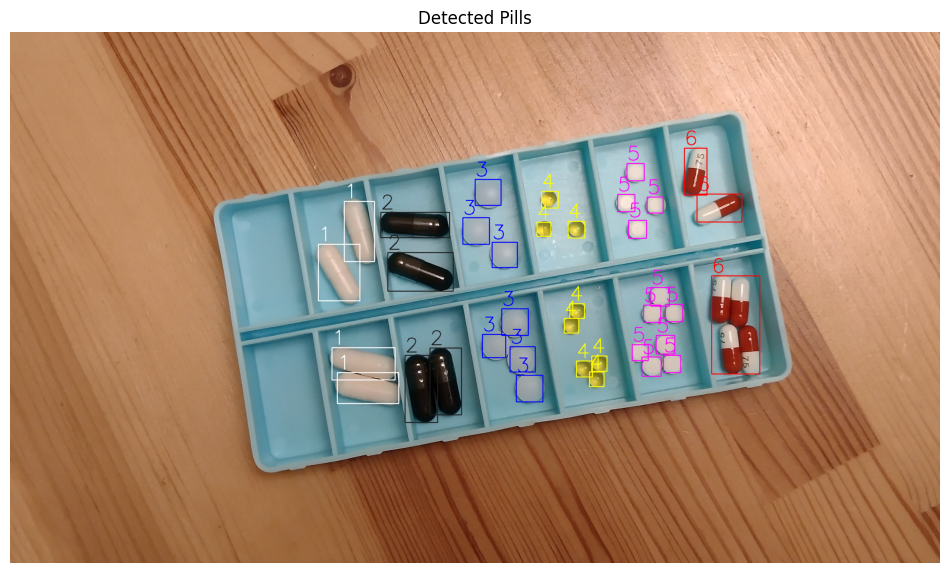

In [13]:
image = calib
objects = detect_objects(image, pilltype = [PillType.CARBON, PillType.PROBIO, PillType.ESPU, PillType.BIOX, PillType.KETO, PillType.LINE])
display_objects(image, objects)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

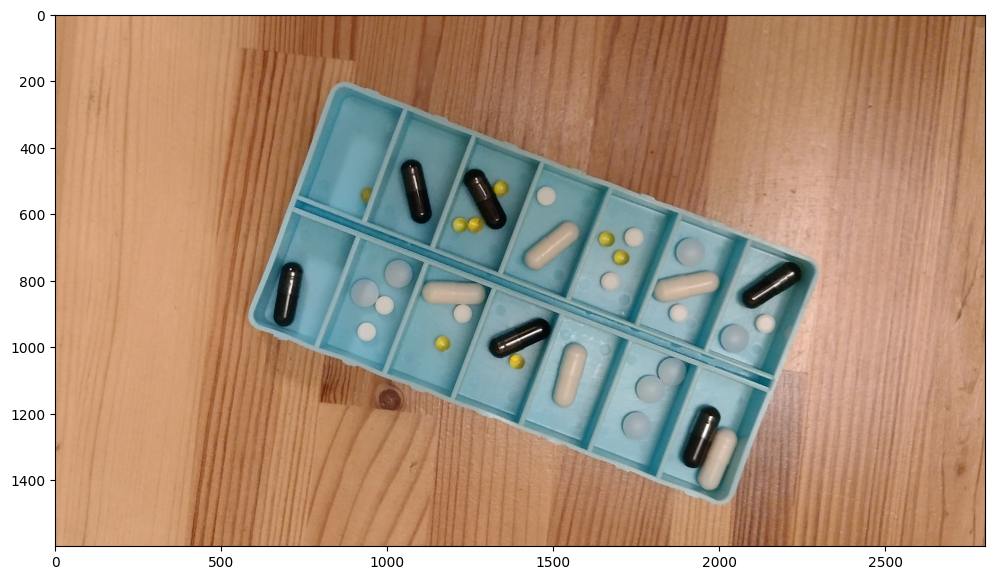

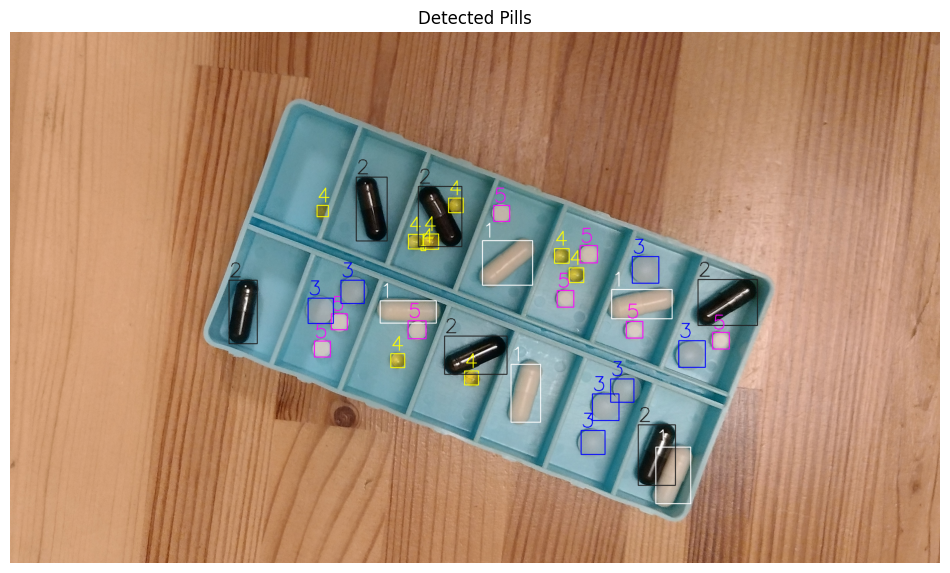

In [14]:
calib2 = cv2.imread('test.png')[..., ::-1]
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib2);

image = calib2

objects = detect_objects(image, pilltype = [PillType.CARBON, PillType.PROBIO, PillType.ESPU, PillType.BIOX, PillType.KETO])

display_objects(image, objects)

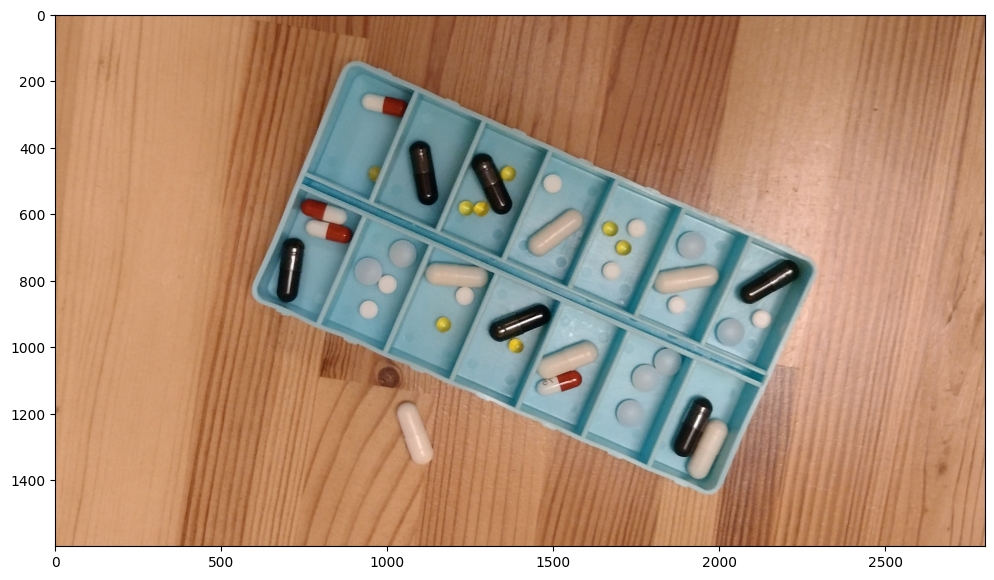

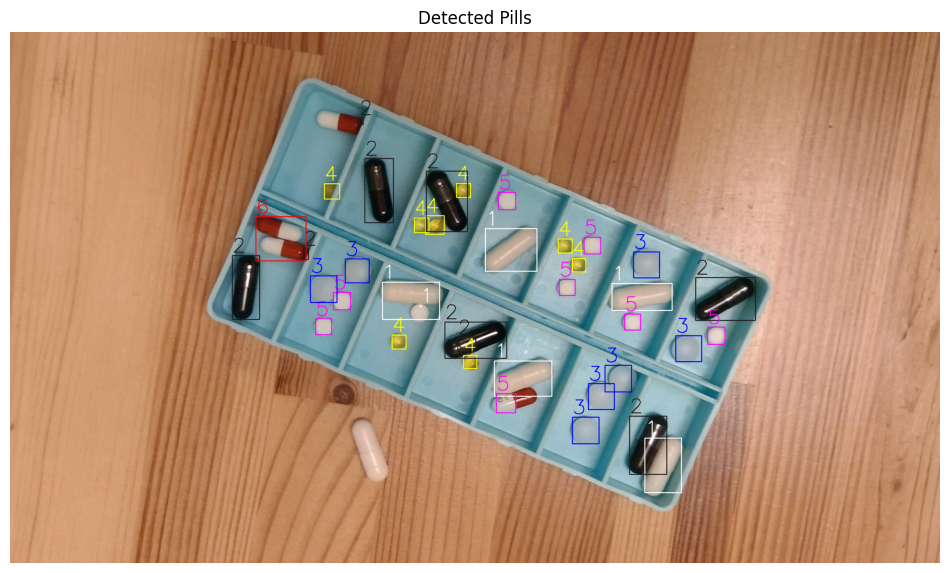

In [16]:
calib3 = cv2.imread('test_line.png')[..., ::-1]
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib3);

image = calib3

objects = detect_objects(image, pilltype = [PillType.CARBON, PillType.PROBIO, PillType.ESPU, PillType.BIOX, PillType.KETO, PillType.LINE])

display_objects(image, objects)

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.